Preprocessing data for statistical analysis and bags of words

In [135]:
import torch
import os
import re
from glob import glob
import textblob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

tokenizer = RegexpTokenizer(r'\w+')

import nltk
# nltk.download("punkt")
#nltk.download('stopwords')
#nltk.download('wordnet')

1 get data and read tsv file

In [206]:
root_folder = os.path.dirname(os.getcwd()) 
datafolder = os.path.join(root_folder,'datasets')
allfiles = glob(os.path.join(datafolder, '*.tsv'))
allfiles

['/Users/shufanxia/Documents/STA561/sta561project/datasets/train.tsv',
 '/Users/shufanxia/Documents/STA561/sta561project/datasets/test.tsv',
 '/Users/shufanxia/Documents/STA561/sta561project/datasets/valid.tsv']

In [28]:
def read_dataframe(tsv_file: str) -> pd.DataFrame:
    
    # creates a "dataframe" or "df" for short. This is similar to a 2-D python dict.
    df = pd.read_csv(tsv_file, delimiter='\t', dtype=object)
    
    # replaces all "null" or "NaN" values with an empty string
    df.fillna("", inplace=True)
    
    # labels the columns in the dataset using the data dictionary described in the README
    df.columns = [
        'id',                # Column 1: the ID of the statement ([ID].json).
        'label',             # Column 2: the label.
        'statement',         # Column 3: the statement.
        'subjects',          # Column 4: the subject(s).
        'speaker',           # Column 5: the speaker.
        'speaker_job_title', # Column 6: the speaker's job title.
        'state_info',        # Column 7: the state info.
        'party_affiliation', # Column 8: the party affiliation.
        
        # Column 9-13: the total credit history count, including the current statement.
        'count_1', # barely true counts.
        'count_2', # false counts.
        'count_3', # half true counts.
        'count_4', # mostly true counts.
        'count_5', # pants on fire counts.
        
        'context' # Column 14: the context (venue / location of the speech or statement).
    ]
    
    return df


In [223]:

#create a dataframe from the training data

file = np.array(allfiles)[np.array(['train' in os.path.basename(x) for x in allfiles])][0]
df_train = read_dataframe(file)
df_train.head()

,id,label,statement,subjects,speaker,speaker_job_title,state_info,party_affiliation,count_1,count_2,count_3,count_4,count_5,context
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7,19,3,5,44,a news release
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15,9,20,19,2,an interview on CNN
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0,3,2,5,1,a an online opinion-piece


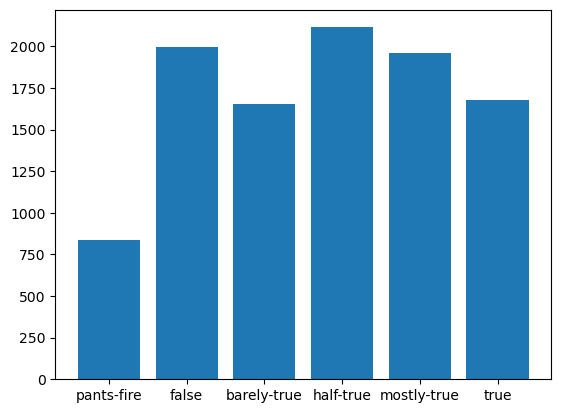

In [249]:
label2num = {'pants-fire':0,
             'false':1,
             'barely-true':2,
             'half-true':3,
             'mostly-true':4,
             'true':5}
df_train['label_num'] = df_train['label'].replace(label2num)
# encode prediction label
y_train = df_train['label_num']>2
plt.bar(label2num.keys(),df_train['label_num'].value_counts().sort_index().values)
plt.show()

preprocessing steps for each column: <br>
- text: tokenization, Bag of Words (BoW) representation <br>
- topic: one-hot-encoding -> make into a binary matrix <br>
- context (last column): search the most common words. filter by the top 10 <br>


In [160]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def clean_text(text):
    '''Text Preprocessing '''
    
    # Convert words to lower case
    text = text.lower()
    # Expand contractions
    text  =  decontracted(text)
    # remove numbers
    text = re.sub(r"\d+",'',text)
    # substitue U.S. with united states
    text = re.sub(r"u.s.",'united states',text)
    # remove punctuation and tokenize
    text = tokenizer.tokenize(text) 
    # remove stopwords
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
    # Lemmatize each token
    lemm = nltk.stem.WordNetLemmatizer()
    text = list(map(lambda word: lemm.lemmatize(word), text))      
    return text

In [250]:
def processRawText(df,vectorizer = None):
    # clean and tokenize raw text
    df['statement_cleaned']  = df['statement'].apply(clean_text)
    
    if not vectorizer:
        # bag of n-gram representation
        vectorizer = CountVectorizer(lowercase=False,
            tokenizer=lambda doc: doc,
            ngram_range=(1,2),
            analyzer = 'word')

        vectorizer.fit(df['statement_cleaned'])
        all_vocabs = vectorizer.get_feature_names_out()
        print('total unique words and n-gram', len(all_vocabs))
    # get the bag of words transfor,ation
    X  = vectorizer.transform(df['statement_cleaned']).toarray()
    df['label_num'] = df['label'].replace(label2num)
    y = df['label_num']>2
    return df, X,y, vectorizer

In [252]:
# clean up and make bag of words embedding for train data, encode y to binary variable
df_train, X_train,y_train, vectorizer=processRawText(df_train,vectorizer = None)
print('true percentage', y_train.sum()/len(y_train))

/Users/shufanxia/opt/miniconda3/envs/STA561/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


total unique words and n-gram 78349
true percentage 0.5617736107041703


In [233]:
index_list = np.arange(0,len(df_train),1)
i = index_list[X_train[:,0]==1][0]
all_vocabs = vectorizer.get_feature_names_out()
print(all_vocabs[:20])
print(df_train['statement'][8319])
print(df_train['statement_cleaned'][8319])

['aa' 'aa aaa' 'aaa' 'aaa bond' 'aaa credit' 'aaron' 'aaron bean' 'aarp'
 'aarp endorsing' 'aarp inconsistently' 'aarp largest' 'aarp say' 'aba'
 'aba criterion' 'abandoned' 'abandoned home' 'abandoned republican'
 'abandoning' 'abandoning dollar' 'abbas']
Florida was the only state during my eight years to go from AA to AAA in its bond rating.
['florida', 'state', 'eight', 'year', 'go', 'aa', 'aaa', 'bond', 'rating']


try a logistic regression


In [247]:
model = LogisticRegression(C= 0.01,penalty="l1",solver="saga",random_state=0)
model.fit(X_train,y_train)


LogisticRegression(C=0.01, penalty='l1', random_state=0, solver='saga')

In [248]:
score = model.score(X_train, y_train)
print('Train score with bow features', score)

Train score with bow features 0.5617736107041703


evaluate on validation set

In [253]:
# clean up and make bag of words embedding for validation data, encode y to binary variable
val_file = np.array(allfiles)[np.array(['valid' in os.path.basename(x) for x in allfiles])][0]
print(val_file)
df_val = read_dataframe(val_file)
df_val, X_val,y_val, vectorizer=processRawText(df_val,vectorizer)
df_val['label_num'] = df_val['label'].replace(label2num)
# encode prediction label
y_val = df_val['label_num']>2
score = model.score(X_val, y_val)
print('Validation score with bow features', score)

/Users/shufanxia/Documents/STA561/sta561project/datasets/valid.tsv
Validation score with bow features 0.5206547155105222
